To-Do list:
Read in dataset
Train-Validation-Test splitting
Clustering
Plotting that
Read the paper from exercise 5 (CNN)
Implement CNN to identify motifs of the polymers

In [16]:
import csv
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

/home/djkeizer/anaconda3/envs/ml4chem/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/djkeizer/anaconda3/envs/ml4chem/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")
Matplotlib is building the font cache; this may take a moment.


In [27]:
csvfile = 'polymers_dataset.csv'
rows = []
fingerprints = []
nonzero_count = 0
with open(csvfile, 'r') as csv_file:
     csv_reader = csv.reader(csv_file, dialect='excel', delimiter=',')
     line_count = 0
     for row in csv_reader:
          if line_count == 0:
               pass
          else:
               rows.append([val for val in row[:3]])
               fingerprints.append([int(val) for val in row[3:]])
          line_count += 1


Printing a certain index with data

In [33]:
nonzero_count = 0
print('Number of polymers: ', len(rows))
index = 411 #Change this value to see the data
print(f"Index {rows[index][0]} with SMILES {rows[index][1]}")
print('Label: ', rows[index][2])
print('Fingerprint: ',fingerprints[index])
for i in range(2048):
     if fingerprints[index][i] != 0:
          nonzero_count += 1
print('Fingerprints == 1: ', nonzero_count)

Number of polymers:  20609
Index 411 with SMILES O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@]([H])1O)([H])[C@]1([H])O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@]([H])1O)([H])[C@@]1([H])N[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@]([H])1O)([H])[C@]1([H])O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O
Label:  oligosaccharide
Fingerprint:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

Draw the selected molecule

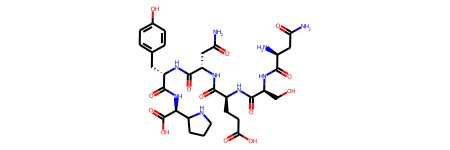

In [29]:
mol = Chem.MolFromSmiles(train[index][1])
mol

Splitting the data into training, validation and testing data

In [31]:
line_count = len(rows)
indices = np.arange(line_count)
np.random.shuffle(indices)
split_train = 80
split_validation = 10
split_test = 10
train_end = int(line_count * split_train / 100)
val_end = train_end + int(line_count * split_validation / 100)
# Split data
train = [rows[i] for i in indices[:train_end]]
validation = [rows[i] for i in indices[train_end:val_end]]
test = [rows[i] for i in indices[val_end:]]
# Fingerprint data
fin_train = [fingerprints[i] for i in indices[:train_end]]
fin_validation = [fingerprints[i] for i in indices[train_end:val_end]]
fin_test = [fingerprints[i] for i in indices[val_end:]]
print(len(train),len(validation),len(test),len(train)+len(validation)+len(test),len(rows))
print(test[len(test)-1])

16487 2060 2062 20609 20609
['4874', 'O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@]([H])1O)([H])[C@@]1([H])O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@]([H])1O)([H])[C@@]1([H])O', 'oligosaccharide']


Calculate the probabilities of the 3 labels

In [35]:
sugar = 0
plastic = 0
peptide = 0

for i in range(len(rows)):
    if rows[i][2] == 'peptide':
        peptide += 1
    elif rows[i][2] == 'plastic':
        plastic += 1
    elif rows[i][2] == 'oligosaccharide':
        sugar += 1

p_sugar = sugar / len(rows)
p_plastic = plastic / len(rows)
p_peptide = peptide / len(rows)
print(f"Probability of peptide, plastic or sugar for the label: {p_peptide:6.3f}, {p_plastic:6.3f}, {p_sugar:6.3f}.")
print('Total probability: ',p_sugar+p_plastic+p_peptide)


Probability of peptide, plastic or sugar for the label:  0.333,  0.330,  0.337.
Total probability:  1.0


Make a CNN to identify polymers

In [36]:
# prepare data loaders for all three sets.
train_dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(validation, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [ ]:
#here goes in PCA code
#will add in later